# RESULTS

In [ ]:
import os
import copy
import time
import shutil
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import io
import cv2
import csv

import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import torch.nn.functional as F
from torchvision import models
from torch.utils.data import Dataset, DataLoader, sampler, random_split
from scipy.stats import chi2_contingency

from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
from sklearn.utils import resample

import wandb
from sklearn.metrics import roc_curve, auc
import warnings
warnings.filterwarnings('ignore')

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

wandb.init(project="AP arreglemho")


wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


Using device: cuda


wandb: Currently logged in as: b-madorell (b-madorell-universitat-de-girona). Use `wandb login --relogin` to force relogin


## CLASSES AND FUNCTIONS

In [ ]:
class CustomDataset(Dataset):
    """
    A custom Dataset class that loads images and their corresponding labels from a DataFrame.
    Each row in the DataFrame should contain the image file path and its label.
    Applies image transformations using torchvision transforms.
    """
    def __init__(self, dataframe, transform=None):
        """
        Initializes the dataset.
        Input:
            dataframe: DataFrame containing image paths and labels.
            transform: Optional transformations to apply to each image.
        """
        self.dataframe = dataframe
        self.transform = transform

    def __len__(self):
        """
        Returns the total number of samples in the dataset
        """
        return len(self.dataframe)

    def __getitem__(self, idx):
        """
        Retrieves a single sample from the dataset.
        Input:
            idx: Index of the sample to retrieve.

        Output:
                image_tensor: Transformed image.
                label: Ground truth label (0 or 1).
                filename: Base name of the image file.
        """
        img_path = self.dataframe.iloc[idx, 0]  # Get image file path
        image = Image.open(img_path).convert('RGB')  # Open and convert to RGB
        label = self.dataframe.iloc[idx, 1]  # Get label (0 or 1)
        
        if self.transform:
            image = self.transform(image)  # Apply data transformations
        
        return image, label, os.path.basename(img_path)  # Return image, label, filename
        return image, label, os.path.basename(img_path)

In [4]:
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

In [5]:
transformers = {'train_transforms' : transforms.Compose([
    transforms.Resize(256),  # Redimensiona la part curta a 256
    transforms.RandomResizedCrop(224),
    transforms.RandomRotation(20),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.RandomAffine(degrees=15, translate=(0.1, 0.1)),
    transforms.ToTensor(),
    transforms.Normalize(mean=mean, std=mean)
]),
'val_transforms' : transforms.Compose([
    transforms.Resize(256),          # Redimensiona la part curta a 256
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
]),
'test_transforms' : transforms.Compose([
    transforms.Resize(256),          # Redimensiona la part curta a 256
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])}

Model and training:

In [ ]:
class Model(nn.Module):
    """
    A custom neural network model based on a pretrained ResNet50 for binary classification (Pneumonia detection).

    - Replaces the ResNet50 classifier with a custom fully connected head.
    - Freezes early layers to focus training on higher-level features and make fine tunning.
    - Includes methods for forward propagation and model training with early stopping and learning rate scheduling.
    - Training metrics and performance are logged using Weights & Biases (wandb).
    """
    def __init__(self):
        """
        Initializes the model by:
        - Loading a pretrained ResNet50.
        - Replacing the default classifier with a custom sequential classifier suited for binary classification.
        - Freezing all layers except 'layer4' and the classifier to fine-tune only the last layers.
        """
        # Load pretrained ResNet50
        super(Model, self).__init__()
        self.model = torchvision.models.resnet50(pretrained=True)
        # Replace the default classifier with a custom one
        self.classifier = nn.Sequential(
            nn.Linear(self.model.fc.in_features, 512),  # Reduces characteristics to 512
            nn.ReLU(),  # Activates the neurons in a non linear way
            nn.Dropout(0.4),  # Reduces overfitting by eliminating connections in each forward pass
            nn.Linear(512, 2)  # Reduces to 2 classes (Pneumonia or No Pneumonia)
            #nn.LogSoftmax(dim=1)  # Converts the outputs into logarithmic probabilities
        )

        # Freeze early layers except 'layer4' and the classifier
        for name, param in self.model.named_parameters():
            if "layer4" not in name and "fc" not in name:
                param.requires_grad = False

        # Replace the original fully connected layer
        self.model.fc = self.classifier

    def forward(self, x):
        """
        Defines the forward pass of the model.
        Input: tensor (image batch).
        Output: logits for classification.
        """
        return self.model(x)   
    
    def fit(self, dataloaders, num_epochs):
        """
        Trains the model using a given number of epochs with early stopping and learning rate scheduling.

        - Uses separate learning rates for the last ResNet block (layer 4) and the classifier.
        - Applies gradient clipping to stabilize training.
        - Logs training and validation metrics (loss and accuracy) to wandb.
        - Saves the best model weights based on validation accuracy.

        Input: 
            dataloaders: Containing 'train' and 'val' DataLoaders.
            num_epochs: Number of epochs to train the model.

        Returns: The trained model with the best validation performance.
        """
        train_on_gpu = torch.cuda.is_available()
        # Optimizer with separate learning rates for the final layers
        optimizer = optim.Adam(
            [
                {"params": self.model.layer4.parameters(), "lr": 1e-4},  # Smaller learning rate
                {"params": self.model.fc.parameters(), "lr": 1e-3}       # Bigger learning rate
            ]
        )
        # Learning rate scheduler
        scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', patience=2)  # Based in val_acc
        # Loss function
        criterion = nn.CrossEntropyLoss()  # Better than NLLLoss
        
        since = time.time()  
        patience = 10
        counter = 0      
        
        # Save the best model weights
        best_model_wts = copy.deepcopy(self.model.state_dict())
        best_acc = 0.0
        if train_on_gpu:
            self.model = self.model.to(device)
        for epoch in range(1, num_epochs + 1):
            print("epoch {}/{}".format(epoch, num_epochs))
            print("-" * 10)            
            
            for phase in ['train', 'val']:
                if phase == 'train':
                    self.model.train()
                else:
                    self.model.eval()                
                    
                running_loss = 0.0
                running_corrects = 0.0                
                
                for inputs, labels, _ in dataloaders[phase]:
                    if train_on_gpu:
                        inputs = inputs.to(device)
                        labels = labels.to(device)
                    optimizer.zero_grad()                    
                    
                    with torch.set_grad_enabled(phase == 'train'):
                        outputs = self.model(inputs)
                        _, preds = torch.max(outputs, 1)
                        loss = criterion(outputs, labels)                        
                        
                        if phase == 'train':
                            loss.backward()
                            torch.nn.utils.clip_grad_norm_(self.model.parameters(), max_norm=1.0)
                            optimizer.step() 
                            
                    running_loss += loss.item() * inputs.size(0)
                    running_corrects += torch.sum(preds == labels.data)                
                    
                epoch_loss = running_loss / len(dataloaders[phase].dataset)
                epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset)                
                
                # We send the metrics to Weights & Biases
                if phase == 'train':
                    wandb.log({"Train Loss": epoch_loss, "Train Accuracy": epoch_acc, "epoch": epoch})
                else:
                    wandb.log({"Validation Loss": epoch_loss, "Validation Accuracy": epoch_acc, "epoch": epoch})                
                    
                print("{} loss:  {:.4f}  acc: {:.4f}".format(phase, epoch_loss, epoch_acc))               
                
                # Early stopping based on validation accuracy
                if phase == 'val':
                    scheduler.step(epoch_loss)
                
                    if epoch_acc > best_acc:
                        best_acc = epoch_acc
                        best_model_wts = copy.deepcopy(self.model.state_dict())        
                        counter = 0
                    else:
                        counter += 1
                    
                    if counter >= patience:
                        print("🛑 Early stopping activat!")
                        self.model.load_state_dict(best_model_wts)  # Get the best model
                        return self.model
                    
        time_elapsed = time.time() - since
        print('time completed: {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
        print("best val acc: {:.4f}".format(best_acc))        
        
        self.model.load_state_dict(best_model_wts)
        return self.model


Evaluation:

In [ ]:
def denormalize(img, mean, std):
    """
    Reverts the normalization applied to an image tensor and ensures pixel values are in [0, 1].

    Input:
        img : A normalized image as a NumPy array of shape (C, H, W), where C is the number of channels.
        mean : The mean values used during normalization, one for each channel.
        std : The standard deviation values used during normalization, one for each channel.
    
    Output: The denormalized image as a NumPy array with pixel values clipped to the range [0, 1].
    """
    mean = np.array(mean)
    std = np.array(std)

    # Reverse the normalization: x_original = x_normalized * std + mean
    img = img * std[:, None, None] + mean[:, None, None]

    # Clip values to ensure they fall within [0, 1] for valid image display
    return np.clip(img, 0, 1)


In [ ]:
def check_accuracy(loader, model, save_path_0, save_path_1, csv_path):
    """
    Evaluates model accuracy on a dataset, saves predictions, and logs results to CSV.

    This function processes a given DataLoader, performs inference using the provided model, saves predicted images in class-specific directories, and writes prediction confidence scores to a CSV file. It also returns prediction and label arrays for further evaluation.

    Input:
        loader : DataLoader containing the dataset to evaluate.
        model : Trained model to use for prediction.
        save_path_0 : Directory path where images predicted as class 0 ()'no_pneumo') will be saved.
        save_path_1 : Directory path where images predicted as class 1 ('pneumo') will be saved.
        csv_path : File path to the CSV file where prediction confidence (max probability) per image will be saved. Each row contains the filename and its associated max probability.

    Output:
        all_preds : Array of predicted class labels.
        all_labels : Array of ground truth labels.
        out : Array of maximum predicted probabilities (confidence scores).
    """

    os.makedirs(save_path_0, exist_ok=True)
    os.makedirs(save_path_1, exist_ok=True)

    with open(csv_path, mode='w', newline='') as csv_file:
        csv_writer = csv.writer(csv_file)
        csv_writer.writerow(["Filename", "Max_Val"])  # Write header

        num_correct = 0
        num_samples = 0
        model.eval()

        # Determine the device used by the model
        device = next(model.parameters()).device

        all_preds = []
        all_labels = []
        out = []

        with torch.no_grad():
            for x, labels, filename in loader:
                x = x.to(device)
                labels = labels.to(device)

                output = model(x)
                outputs = torch.exp(output)  # Convert log-probs to probabilities
                max_val, predictions = outputs.max(1)

                num_correct += (predictions == labels).sum()
                num_samples += predictions.size(0)

                # Save images and log predictions
                for j in range(x.size(0)):
                    imatge = x[j].cpu().numpy()
                    imatge = denormalize(imatge, mean, std)
                    imatge = np.transpose(imatge, (1, 2, 0))

                    predicted_class = predictions[j].item()
                    save_path = save_path_0 if predicted_class == 0 else save_path_1

                    image_path = os.path.join(save_path, f"{filename[j].split('.')[0]}_{max_val[j].item():.4f}.jpg")
                    plt.imsave(image_path, imatge)

                    csv_writer.writerow([filename[j].split('.')[0], max_val[j].item()])

                all_preds.append(predictions.cpu().numpy())
                all_labels.append(labels.cpu().numpy())
                out.append(max_val.cpu().numpy())

        all_preds = np.concatenate(all_preds)
        all_labels = np.concatenate(all_labels)
        out = np.concatenate(out)

        print(f'Got {num_correct} / {num_samples} with accuracy {float(num_correct) / float(num_samples) * 100:.2f}%')

        return all_preds, all_labels, out


Mètriques d'avaluació:

In [ ]:
def matriu_de_confusio_i_classificacio_report(all_labels, all_preds):
    """
    Displays and logs a confusion matrix and classification report using Weights & Biases.

    This function computes the confusion matrix and classification report for binary classification (pneumonia detection), displays them using matplotlib, and logs both to Weights & Biases (wandb) for experiment tracking.

    Input:
        all_labels : Ground truth labels (0 or 1) for each prediction.
        all_preds : Predicted labels (0 or 1) from the model.
    """

    conf_mat = confusion_matrix(all_labels, all_preds)
    target_names = ['no_pneumo', 'pneumo']

    disp = ConfusionMatrixDisplay(confusion_matrix=conf_mat, display_labels=target_names)
    disp.plot()

    clas_rep = classification_report(all_labels, all_preds, target_names=target_names)
    print(clas_rep)

    wandb.log({
        "Classification report": clas_rep,
        "Confusion matrix": wandb.Image(disp.figure_)
    })


In [ ]:
def probabilitats_sortides(out, all_preds):
    """
    Plots and logs a histogram of predicted softmax probabilities for each class.

    This function separates output probabilities by predicted class (0 or 1), creates a histogram comparing the distributions of softmax scores, and logs the result to Weights & Biases (wandb). It also displays the histogram locally.

    Inputs:
        out : Array of softmax probabilities (max values) for each prediction.
        all_preds : Predicted class labels (0 or 1) corresponding to each probability in `out`.

    """

    outs_class_0 = out[all_preds == 0]  # Class 0: Pneumo
    outs_class_1 = out[all_preds == 1]  # Class 1: No pneumo

    plt.title('PREDICTED PROBABILITIES')
    plt.hist(outs_class_0, bins=20, alpha=0.8, color='pink', label='Pneumo')
    plt.hist(outs_class_1, bins=20, alpha=0.8, color='orange', label='No pneumo')
    plt.xticks([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0])
    plt.xlabel('Softmax Probabilities')
    plt.ylabel('Frequency')
    plt.legend(loc='upper left')

    # Save image to buffer
    buf = io.BytesIO()
    plt.savefig(buf, format='png', bbox_inches='tight')
    plt.close()
    buf.seek(0)

    # Convert buffer to numpy image
    im = Image.open(buf)
    im_np = np.array(im)

    # Log to wandb
    wandb.log({"Probabilitats sortida": wandb.Image(im_np)})

    # Show locally
    im.show()


In [ ]:
def corva_roc(all_labels, all_preds): 
    """
    Generates and logs a Receiver Operating Characteristic (ROC) curve based on true labels and predicted probabilities.

    This function calculates the ROC curve and the Area Under the Curve (AUC) to evaluate the performance of a binary classifier. The ROC curve is plotted, saved to a buffer, converted to a NumPy image, logged to Weights & Biases (wandb), and then discarded.

    Inputs:
        all_labels : Ground truth binary labels (0 or 1).
        all_preds : Predicted probabilities or confidence scores for the positive class.
    """

    # Calculate ROC curve
    fpr, tpr, thresholds = roc_curve(all_labels, all_preds)
    print(fpr)
    print(tpr)

    # Calculate AUC
    roc_auc = auc(fpr, tpr)

    # Plot ROC curve
    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc="lower right")
    
    # Save image to buffer
    buf = io.BytesIO()
    plt.savefig(buf, format='png', bbox_inches='tight')
    plt.close()  
    buf.seek(0)

    # Convert buffer to numpy image
    im = Image.open(buf)
    im_np = np.array(im)

    # Log to wandb
    wandb.log({"ROC": wandb.Image(im_np)})


Save misclassified and good classified:

In [ ]:
def find_misclassified(ground_truth_path, predicted_path, misclassified_path):
    """
    Identifies and copies misclassified images from the ground truth folder to a designated output folder based on filenames present in the predicted folder.

    This function assumes that the predicted images are named in the format 'filename_confidence.jpg', and attempts to match them with ground truth images using the base filename (excluding the confidence score and extension).

    Input:
        ground_truth_path : Path to the folder containing ground truth images (.png format).
        predicted_path : Path to the folder containing predicted images with confidence scores in the filenames.
        misclassified_path : Destination folder where matched (misclassified) ground truth images will be copied.
    """

    # List all images in the ground truth folder
    ground_truth_images = set(os.listdir(ground_truth_path))

    # List all images in the predicted folder
    predicted_images = set(os.listdir(predicted_path))

    # Extract base names from predicted filenames (e.g., 'img123_0.85.jpg' → 'img123.png')
    predicted_base_names = {filename.rsplit('_', 1)[0] + '.png' for filename in predicted_images}

    # Extract base names from ground truth filenames (e.g., 'img123.png' → 'img123')
    ground_truth_base_names = {os.path.splitext(filename)[0] for filename in ground_truth_images}

    # Identify images present in both predicted and ground truth sets (potentially misclassified)
    misclassified_images = ground_truth_images.intersection(predicted_base_names)
    print(misclassified_images)

    # Copy the matching ground truth images to the misclassified folder
    for image in misclassified_images:
        shutil.copy(os.path.join(ground_truth_path, image), os.path.join(misclassified_path, image))


In [ ]:
def guardar_misclassified_images(misclassified_ok_as_esq_path, misclassified_dreta_as_esq_path, save_path_0, save_path_1):
    """
    Identifies and saves misclassified images into separate directories based on their confusion type.

    This function uses the helper `find_misclassified` to compare predicted images against ground truth labels and organizes the misclassified results into dedicated folders for further inspection.

    Input:
        misclassified_ok_as_esq_path : Path where ground truth 'no_pneumo' images incorrectly predicted as 'pneumo' will be saved.
        misclassified_dreta_as_esq_path : Path where ground truth 'pneumo' images incorrectly predicted as 'no_pneumo' will be saved.
        save_path_0 : Path containing predicted 'no_pneumo' images.
        save_path_1 : Path containing predicted 'pneumo' images.
    """

    # Create directories to store the misclassified images
    os.makedirs(misclassified_ok_as_esq_path, exist_ok=True)
    os.makedirs(misclassified_dreta_as_esq_path, exist_ok=True)

    # Misclassified: 'no_pneumo' (label 0) predicted as 'pneumo' (label 1)
    find_misclassified(gth_0, save_path_1, misclassified_ok_as_esq_path)

    # Misclassified: 'pneumo' (label 1) predicted as 'no_pneumo' (label 0)
    find_misclassified(gth_1, save_path_0, misclassified_dreta_as_esq_path)


## MAIN

In [ ]:
################# DIRECTORIES #################
## Images ##
root_path = '/home/nuria/rsna-pneumonia-challenge/dataset_three_class/'
train_pneumo_images = root_path + 'images/train'
val_pneumo_images = root_path + 'images/val'
## Csv ##
#train_data = pd.read_csv('/home/bertam/CHALLENGE/train_data_PA.csv')
#val_data = pd.read_csv('/home/bertam/CHALLENGE/val_data_PA.csv')
## Ground truth ##
gth_0= "./ground_truth/no_pneumo"
gth_1 = "./ground_truth/si_pneumo"
## Where we save classified images ##
save_path_0= "./appa_arreg_bofinal/classified_images/no_pneumo"
save_path_1= "./appa_arreg_bofinal/classified_images/pneumo"
csv_path = "./appa_arreg_bofinal/AP_nw_nls_cf_10_01.csv"
## Misclassified ##
misclassified_no_as_pn = "./appa_arreg_bofinal/misclassified/no_pneumo_as_pneumo"
misclassified_pn_as_no = "./appa_arreg_bofinal/misclassified/pneumo_as_no_pneumo"
## Good classification ##
good_classification_no_pneumo= "./appa_arreg_bofinal/correct_class/no_pneumo"
good_classification_pneumo= "./appa_arreg_bofinal/correct_class/pneumo"


image_data = pd.read_csv('/home/bertam/CHALLENGE/stage2_train_metadata.csv')
# -----------------------------
# Assign full image paths
# -----------------------------
image_data['full_path'] = ' '
train_rows_pa, val_rows_pa = [], []
train_rows_ap, val_rows_ap = [], []

for idx, row in image_data.iterrows():
    filename = row['patientId'] + '.png'
    # I have to check if the image is in the train or val directory
    train_image_path = os.path.join(train_pneumo_images, filename)
    val_image_path = os.path.join(val_pneumo_images, filename)
    # I check if the path exists
    # I separate the images depending on their position "AP" or "PA"
    if os.path.isfile(train_image_path):
        if row['position']=='PA':
            image_data.loc[idx,'full_path']= train_image_path
            train_rows_pa.append({'path_im': train_image_path, 'label': row['Target']})
        elif row['position']=='AP':
            image_data.loc[idx,'full_path']= train_image_path
            train_rows_ap.append({'path_im': train_image_path, 'label': row['Target']})
    else:
        if row['position']=='PA':
            val_image_path= os.path.join(val_pneumo_images,p)
            image_data.loc[idx,'full_path']= val_image_path
            val_rows_pa.append({'path_im': val_image_path, 'label': row['Target']})
        elif row['position']=='AP':
            val_image_path= os.path.join(val_pneumo_images,p)
            image_data.loc[idx,'full_path']= val_image_path
            val_rows_ap.append({'path_im': val_image_path, 'label': row['Target']})

# Convert to DataFrames
train_data_pa, train_data_ap = pd.DataFrame(train_rows_pa), pd.DataFrame(train_rows_ap)
val_data_pa, val_data_ap = pd.DataFrame(val_rows_pa), pd.DataFrame(val_rows_ap)

# Remove duplicates
for df in [train_data_pa, train_data_ap, val_data_pa, val_data_ap]:
    df.drop_duplicates(inplace=True)

# -----------------------------
# Downsample to balance classes
# -----------------------------

print(train_data_pa['label'].value_counts())
print(val_data_pa['label'].value_counts())
print(train_data_ap['label'].value_counts())
print(val_data_ap['label'].value_counts())

# Downsample AP data
train_0_ap = train_data_ap[train_data_ap['label'] == 0]
train_1_ap = train_data_ap[train_data_ap['label'] == 1]
data_train_balanced_ap = pd.concat([
    resample(train_0_ap, replace=False, n_samples=1084, random_state=42),
    resample(train_1_ap, replace=False, n_samples=1084, random_state=42)
])

# Downsample PA data
train_0_pa = train_data_pa[train_data_pa['label'] == 0]
data_train_balanced_pa = pd.concat([
    resample(train_0_pa, replace=False, n_samples=1084, random_state=42),
    train_data_pa[train_data_pa['label'] == 1]
])

# Downsample validation data
val_0_ap = val_data_ap[val_data_ap['label'] == 0]
val_1_ap = val_data_ap[val_data_ap['label'] == 1]
data_val_balanced_ap = pd.concat([
    resample(val_0_ap, replace=False, n_samples=264, random_state=42),
    resample(val_1_ap, replace=False, n_samples=264, random_state=42)
])

val_0_pa = val_data_pa[val_data_pa['label'] == 0]
data_val_balanced_pa = pd.concat([
    resample(val_0_pa, replace=False, n_samples=264, random_state=42),
    val_data_pa[val_data_pa['label'] == 1]
])

# Final training and validation datasets
train_data = pd.concat([data_train_balanced_ap, data_train_balanced_pa]).sample(frac=1, random_state=42).reset_index(drop=True)
val_data = pd.concat([data_val_balanced_ap, data_val_balanced_pa]).sample(frac=1, random_state=42).reset_index(drop=True)

#Prove that we did it well
print(val_data['label'].value_counts())
print(train_data['label'].value_counts())

# Split validation to get test set
val_data, test_data = train_test_split(val_data, test_size=0.5, random_state=42)

# -----------------------------
# Dataset and Transforms
# -----------------------------
# Apply transforms to datasets
train_trsf = CustomDataset(train_data, transformers['train_transforms'])
val_trsf = CustomDataset(val_data, transformers['val_transforms'])
test_trsf = CustomDataset(test_data, transformers['test_transforms'])

# DataLoader setup
categories = ['train', 'val', 'test']
dset = {'train': train_trsf, 'val': val_trsf, 'test': test_trsf}
dataloaders = {x: DataLoader(dset[x], batch_size=32, shuffle=True, num_workers=0) for x in categories}



################# CREEM EL MODEL I HI CARREGEUEM ELS PESOS GUARDATS #########################
# Calling the model and fit on training data:
model = Model()
state_dict = torch.load("./Best_weights/no_fer_Cas_PAAP_def.pth")
model.load_state_dict(state_dict, strict=False)
model_ft = model.model
model_ft.to(device)


                              patientId      x      y  width  height  Target  \
0  0004cfab-14fd-4e49-80ba-63a80b6bddd6    NaN    NaN    NaN     NaN       0   
1  00313ee0-9eaa-42f4-b0ab-c148ed3241cd    NaN    NaN    NaN     NaN       0   
2  00322d4d-1c29-4943-afc9-b6754be640eb    NaN    NaN    NaN     NaN       0   
3  003d8fa0-6bf1-40ed-b54c-ac657f8495c5    NaN    NaN    NaN     NaN       0   
4  00436515-870c-4b36-a041-de91049b9ab4  264.0  152.0  213.0   379.0       1   

                          class  age sex modality position  \
0  No Lung Opacity / Not Normal   51   F       CR       PA   
1  No Lung Opacity / Not Normal   48   F       CR       PA   
2  No Lung Opacity / Not Normal   19   M       CR       AP   
3                        Normal   28   M       CR       PA   
4                  Lung Opacity   32   F       CR       AP   

                                           full_path  
0                                                     
1                                   

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [ ]:
################ EVALUATION ##################
all_preds, all_labels, out =check_accuracy(dataloaders['test'], model_ft, save_path_0, save_path_1, csv_path)

Got 690 / 939 with accuracy 73.48%


              precision    recall  f1-score   support

   no_pneumo       0.72      0.79      0.75       485
      pneumo       0.75      0.68      0.71       454

    accuracy                           0.73       939
   macro avg       0.74      0.73      0.73       939
weighted avg       0.74      0.73      0.73       939



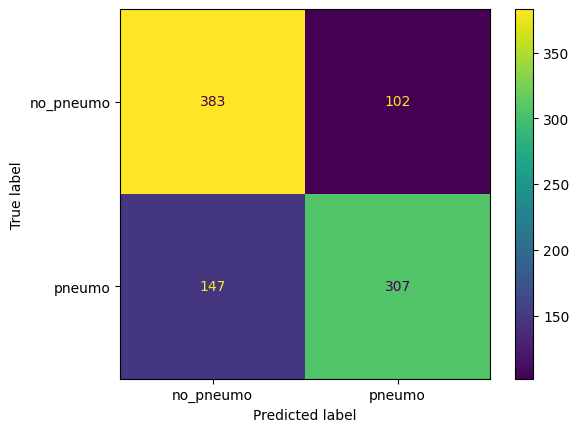

In [ ]:
################ CONFUSION MATRIX ###############
matriu_de_confusio_i_classificacio_report(all_labels,all_preds)

In [ ]:
############### OUTPUT PROBABILITIES ################
probabilitats_sortides(out, all_preds)

Error: no "view" rule for type "image/png" passed its test case
       (for more information, add "--debug=1" on the command line)


In [ ]:
############### ROC CURVE #################
corva_roc(all_labels, out)


[0.         0.21030928 1.        ]
[0.         0.67621145 1.        ]


In [ ]:
############### SAVE GOOD CLASSIFIED ADN MISCLASSIFIED IMAGES ###############
guardar_misclassified_images(misclassified_no_as_pn, misclassified_pn_as_no, save_path_0, save_path_1)
guardar_misclassified_images(good_classification_no_pneumo, good_classification_pneumo, save_path_1, save_path_0)

{'7fec8ddf-30d0-417e-b699-f75d862c7070.png', '58ad2808-fae9-4079-99b7-3f3eae239cac.png', 'e1215cb9-2d8d-4ade-846e-4328e7fa7006.png', 'a18358dc-b553-4fbd-bff4-33888b734eac.png', 'df09db89-b77f-424e-b9cc-6ba00dd047bd.png', 'da4d442b-bd4a-4703-9180-f437a5129444.png', 'e304f03c-1510-484e-afc0-aacec02c1b92.png', '43b42736-57c4-447d-9c50-19b92dcde9e3.png', '4f80b758-d33c-4e13-be26-55273d12c398.png', '73827f0b-0bc9-47eb-8249-14621ad77f5a.png', 'e5f292ae-f1e5-497c-b0a0-68f1aa2196b2.png', '10aa6a8e-4ece-4bde-b3d1-4406ee847cc2.png', '84a0590a-8a58-4a17-8e56-fa9229652d60.png', '1c2707d4-9385-4228-823c-51fb2a956646.png', 'f55de1b9-73f2-487c-b717-c09b047a388b.png', '865707e8-f2c1-47e8-a832-778ca4350c54.png', 'ec1aec71-ffe4-450d-bcf4-7b4fc52d31d5.png', '642da3d2-2da6-4973-9406-9d88c0f2f2c2.png', 'e08e0a02-10a5-4589-b17f-dc336d872155.png', '2626a2bb-234f-4309-aff4-317f6fac9b06.png', 'd6829280-5545-4b88-9cae-8b09ffe5b4cc.png', '15ec434a-959d-4e67-b1c2-2e9fa10b880a.png', '53b42127-3666-4397-9c0c-f2073d